In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
import zipfile
import os

zip_file_path = "mask_images_ready.zip"
destination_folder = "FACE MASK DETECTION"

try:
    # Check if the folder exists already
    if not os.path.exists(destination_folder):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
        print(f"Dataset extracted to: {destination_folder}")
    else:
        print("Folder already exists. Skipping extraction.")
except Exception as e:
    print(f"An error occurred: {e}")


Folder already exists. Skipping extraction.


In [4]:
# Dataset class
class FaceMaskDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Paths
data_dir = "FACE MASK DETECTION/mask_images_ready"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")
model_save_path = "FaceMaskModel.pt"


In [7]:
# Helper to load images
def load_images_and_labels(base_dir):
    image_paths, labels = [], []
    for label_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, label_name)
        if os.path.isdir(class_path):
            label = 1 if label_name == "1" else 0
            for file in os.listdir(class_path):
                if file.endswith(".png"):
                    image_paths.append(os.path.join(class_path, file))
                    labels.append(label)
    return image_paths, labels

train_paths, train_labels = load_images_and_labels(train_dir)
val_paths, val_labels = load_images_and_labels(val_dir)
test_paths, test_labels = load_images_and_labels(test_dir)

In [8]:
# Create datasets
train_dataset = FaceMaskDataset(train_paths, train_labels, transform=transform)
val_dataset = FaceMaskDataset(val_paths, val_labels, transform=transform)
test_dataset = FaceMaskDataset(test_paths, test_labels, transform=transform)


In [9]:
# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch

class FaceMaskModel(nn.Module):
    def __init__(self):
        super(FaceMaskModel, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceMaskModel().to(device)




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/chiragdua/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:05<00:00, 8.67MB/s]


In [17]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Set up your datasets (training, validation, etc.)
# Assuming FaceMaskDataset is already defined

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 12
train_loss_values, train_accuracy_values = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_accuracy = correct / total
    train_loss = running_loss / len(train_loader)

    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
    print("-------------------------------")


Epoch 1/12
Train Loss: 0.1754 | Train Accuracy: 84.72%
-------------------------------
Epoch 2/12
Train Loss: 0.0002 | Train Accuracy: 100.00%
-------------------------------
Epoch 3/12
Train Loss: 0.0001 | Train Accuracy: 100.00%
-------------------------------
Epoch 4/12
Train Loss: 0.0003 | Train Accuracy: 100.00%
-------------------------------
Epoch 5/12
Train Loss: 0.0001 | Train Accuracy: 100.00%
-------------------------------
Epoch 6/12
Train Loss: 0.0025 | Train Accuracy: 100.00%
-------------------------------
Epoch 7/12
Train Loss: 0.2029 | Train Accuracy: 95.83%
-------------------------------
Epoch 8/12
Train Loss: 0.0503 | Train Accuracy: 98.61%
-------------------------------
Epoch 9/12
Train Loss: 0.0017 | Train Accuracy: 100.00%
-------------------------------
Epoch 10/12
Train Loss: 0.0372 | Train Accuracy: 98.61%
-------------------------------
Epoch 11/12
Train Loss: 0.0302 | Train Accuracy: 98.61%
-------------------------------
Epoch 12/12
Train Loss: 0.0001 | Tr

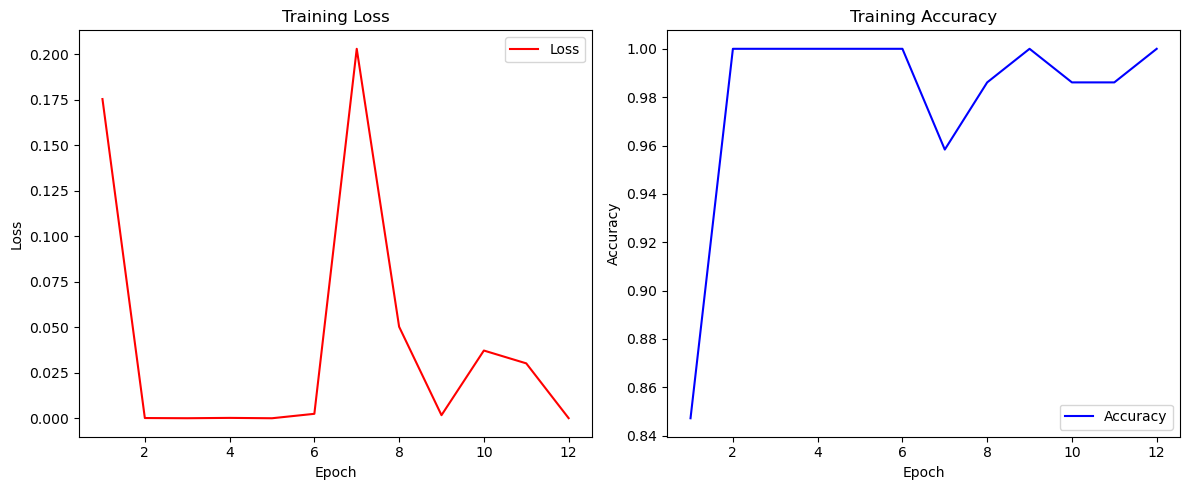

In [18]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label="Loss", color="red")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_values, label="Accuracy", color="blue")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to FaceMaskModel.pt
